In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
cd gdrive/MyDrive/NESTQUANT/data

/content/gdrive/MyDrive/NESTQUANT/data


## import lib and create function

In [1]:
import os
import gc
import math
import sklearn
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
from datetime import datetime

In [ ]:
from preprocess import *

## Read and preprocess data

In this part, we can optimize the model by adding more external data from other sources: crypto, stocks,... and internal data: return, volumne

In [4]:
path = '/Users/nguyenhuyhai/202224/NEST_QUANT/data/'

In [5]:
"""
optimizable
"""
# path = '/content/gdrive/MyDrive/NESTQUANT/data/'

"""
BTC data path
"""
path_BTC = path + 'BTC/BTCUSDT'
path_LABEL = path + 'BTC/SYMBOL=BTCUSDT.parquet'

"""
external data path
"""
path_ETHUSDT = path+ 'coin/ETHUSDT'
path_LTCUSDT = path+ 'coin/LTCUSDT'
path_CPILFESL = path + 'FRED/CPILFESL.parquet'
path_EURUSD = path + 'fx/C_EURUSD'
path_SPY = path+'stock/SPY'

"""
Add more external datapath in here

"""


'\nAdd more external datapath in here\n\n'

In [6]:
"""
BTC preprocessing
""" 
df_Label = pd.read_parquet(path_BTC)
df_BTC = pd.read_parquet(path_LABEL)

df_BTCLabel = df_BTC.join(df_Label, how='inner')
df_BTCLabel = df_BTCLabel.drop(columns=["YEAR_AND_MONTH","SYMBOL"])

In [7]:
"""
optimizable
"""

"""
External preprocessing
"""
df_BTCLabel = preprocess_df(df_BTCLabel, "BTC",1, 12)
df_ETHUSDT = preprocess_df(pd.read_parquet(path_ETHUSDT),"ETHUSDT", 1, 12)
df_LTCUSDT = preprocess_df(pd.read_parquet(path_LTCUSDT),"LTCUSDT",1, 12)
df_EURUSD = preprocess_df(pd.read_parquet(path_EURUSD),"EURUSD", 1, 12)
df_SPY = preprocess_df(pd.read_parquet(path_SPY),"SPY", 1, 12)
"""
add more external data with external path
"""


'\nadd more external data with external path\n'

In [8]:
df_BTCLabel = df_BTCLabel.dropna()
df_ETHUSDT = df_ETHUSDT.dropna()
df_LTCUSDT = df_LTCUSDT.dropna()
df_EURUSD = df_EURUSD.dropna()
df_SPY = df_SPY.dropna()

In [9]:
df_CPILFESL = pd.read_parquet(path_CPILFESL)
df_CPILFESL = get_dupp(df_CPILFESL)
df_CPILFESL["OPEN_TIME"] = df_CPILFESL["DATE"].apply(lambda x: int(datetime.timestamp(x)) *1000)
df_CPILFESL = df_CPILFESL.drop("DATE", axis= 1)
df_CPILFESL = df_CPILFESL.set_index("OPEN_TIME")

/var/folders/hh/60pmh2sx0f3bb29z6_vx_9tm0000gn/T/ipykernel_67641/3569764382.py:62: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  expanded_dff = expanded_dff.append(temp_dff, ignore_index=True)
/var/folders/hh/60pmh2sx0f3bb29z6_vx_9tm0000gn/T/ipykernel_67641/3569764382.py:62: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  expanded_dff = expanded_dff.append(temp_dff, ignore_index=True)
/var/folders/hh/60pmh2sx0f3bb29z6_vx_9tm0000gn/T/ipykernel_67641/3569764382.py:62: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  expanded_dff = expanded_dff.append(temp_dff, ignore_index=True)
/var/folders/hh/60pmh2sx0f3bb29z6_vx_9tm0000gn/T/ipykernel_67641/3569764382.py:62: FutureWarning: The frame.append method is deprecated and will be remove

Merge external data

In [96]:
df_BTCLabel1 = df_BTCLabel.join(df_ETHUSDT, how = 'inner')
df_BTCLabel2 = df_BTCLabel1.join(df_EURUSD, how="left").bfill().ffill()
df_BTCLabel3 = df_BTCLabel2.join(df_LTCUSDT, how="left").bfill().ffill()
df_BTCLabel4 = df_BTCLabel3.join(df_SPY, how="left").bfill().ffill()
df_BTCLabel5 = df_BTCLabel4.join(df_CPILFESL, how="left").bfill().ffill().reset_index()

Get features from dataframe, here I just only get:  "OPEN_TIME","OPEN_BTC","HIGH_LTCUSDT","LABEL_BTC","VOLABILITY_BTC_23", however, we can get moreeee

## Preprocessing data

### check corr

In [97]:
time_lst = df_BTCLabel5.OPEN_TIME.tolist()

In [98]:
delta = 200
rangee = 500
time_lst = df_BTCLabel5.OPEN_TIME.tolist()

In [25]:
df_corr = check_cor(df_BTCLabel5, rangee, delta, time_lst, 'LABEL_BTC')

In [94]:
df_corr[:12]["index"].tolist()

['OPEN_BTC',
 'CLOSE_BTC',
 'LOW_BTC',
 'HIGH_BTC',
 'OPEN_ETHUSDT',
 'LOW_ETHUSDT',
 'CLOSE_ETHUSDT',
 'HIGH_ETHUSDT',
 'CLOSE_LTCUSDT',
 'LOW_LTCUSDT',
 'OPEN_LTCUSDT',
 'HIGH_LTCUSDT']

### Choosing feature

In [100]:
"""
optimizable
"""

df_BTCLabel5  = df_BTCLabel5[["OPEN_TIME",'OPEN_BTC',
 'CLOSE_BTC',
 'LOW_BTC',
 'HIGH_BTC',
 'OPEN_ETHUSDT',
 'LOW_ETHUSDT',
 'CLOSE_ETHUSDT',
 'HIGH_ETHUSDT',
 'CLOSE_LTCUSDT',
 'LOW_LTCUSDT',
 'OPEN_LTCUSDT',
 'HIGH_LTCUSDT',
 'LABEL_BTC']]

## Model training

take train, test data

In [101]:
x = df_BTCLabel5.drop(['LABEL_BTC'],axis=1)
y = df_BTCLabel5["LABEL_BTC"]

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.047, shuffle=False)


In [102]:
time_train = x_train.OPEN_TIME.tolist()

Training

In [ ]:
"""
optimizable
"""
delta = 200 

start_training_OPEN_TIME = 500
model_predicted_scores = []
models = []
t = 0
for i in range(start_training_OPEN_TIME, len(time_train), delta):
    t+=1
    tmp_train_df = df_BTCLabel5[(df_BTCLabel5.OPEN_TIME >= time_train[i-start_training_OPEN_TIME])&(df_BTCLabel5.OPEN_TIME < time_train[i-delta])]
    x_trainn = tmp_train_df.drop(['LABEL_BTC'],axis=1)
    y_trainn = tmp_train_df["LABEL_BTC"]

    tmp_valid_df = df_BTCLabel5[(df_BTCLabel5.OPEN_TIME >= time_train[i-delta])&(df_BTCLabel5.OPEN_TIME < time_train[i])]
    x_validd = tmp_valid_df.drop(['LABEL_BTC'],axis=1)
    y_validd = tmp_valid_df["LABEL_BTC"]

    train_data = lgb.Dataset(x_trainn, label=pd.DataFrame(y_trainn), params={'verbose': -1})
    valid_data = lgb.Dataset(pd.DataFrame(x_validd), label=pd.DataFrame(y_validd), params={'verbose': -1}, reference=train_data)

    """
    optimizable
    """

    param = { 
        'boosting_type': 'goss',
        'max_depth': 4,
        'num_leaves': 15,
        'learning_rate': 0.08,
        'objective': "regression",
        'early_stopping_rounds': 64,
        'metric': 'mse',
        'num_boost_round': 100,
        'num_iterations': 256
    #     'bagging_fraction': 0.8
    }
    if  t == 1:
      model = lgb.train(
        param,
        train_data,
        valid_sets=[train_data, valid_data],
        valid_names=['train', 'valid'],
        verbose_eval=False)
    else:
      model = lgb.train(
          param,
          train_data,
          valid_sets=[train_data, valid_data],
          valid_names=['train', 'valid'],
          verbose_eval=False,
          init_model = models[-1])

    #model_predicted_scores.append([(model.predict(x_trainn)-y_trainn).abs().mean(), (model.predict(x_validd)-y_validd).abs().mean(), (model.predict(x_testt)-y_testt).abs().mean()])

    models.append(model)



### Predicting

In [104]:
pred=model.predict(x_test)
submit=pd.DataFrame(columns=['OPEN_TIME','PREDICTION'])
submit['OPEN_TIME']=x_test["OPEN_TIME"]
submit['PREDICTION']=pred.flatten()

testt=pd.DataFrame(columns=['TEST','PREDICTION'])

testt['TEST']=y_test
testt['PREDICTION']=pred.flatten()


In [105]:
testt

,TEST,PREDICTION
45101,0.418685,0.409105
45102,0.424813,0.412203
45103,0.431807,0.413986
45104,0.430808,0.348928
45105,0.438924,0.417026
...,...,...
47321,0.448246,0.203763
47322,0.470401,0.221161
47323,0.468764,0.225904
47324,0.474988,0.220162


In [106]:
testt.corr()

,TEST,PREDICTION
TEST,1.000000,0.052434
PREDICTION,0.052434,1.000000


In [43]:
pwd

'/Users/nguyenhuyhai/202224/NEST_QUANT/github/NESTQUANTT/code'

In [47]:
cd '/Users/nguyenhuyhai/202224/NEST_QUANT/github/NESTQUANTT/data_submit/'

/Users/nguyenhuyhai/202224/NEST_QUANT/github/NESTQUANTT/data_submit


In [49]:
submit.to_csv("range_500_delta_200_top15feat.csv")

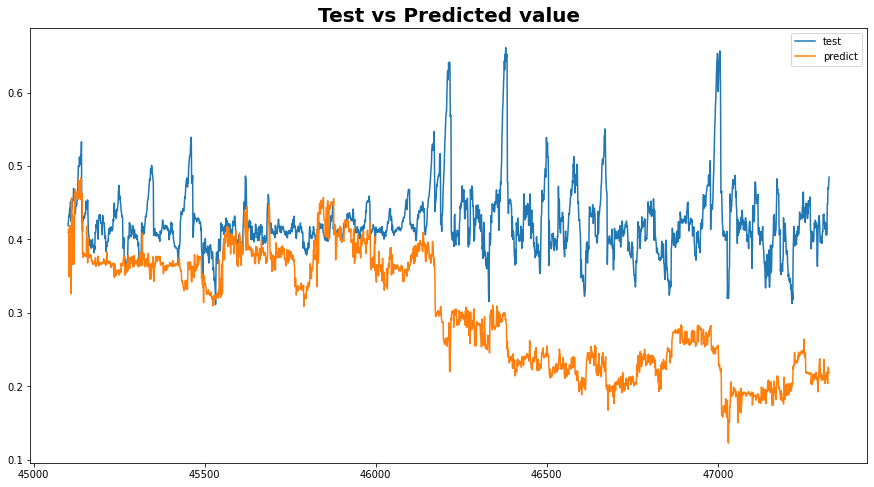

In [107]:
fig=plt.figure(figsize=(15,8))
plt.title("Test vs Predicted value", size=20, weight='bold')
plt.plot(testt)
plt.legend(['test','predict'])


In [40]:
feat_imp = pd.DataFrame([model.feature_name(), model.feature_importance('gain')]).T
feat_imp.columns=['Name', 'Feature Importance']
feat = feat_imp.sort_values("Feature Importance", ascending=False)

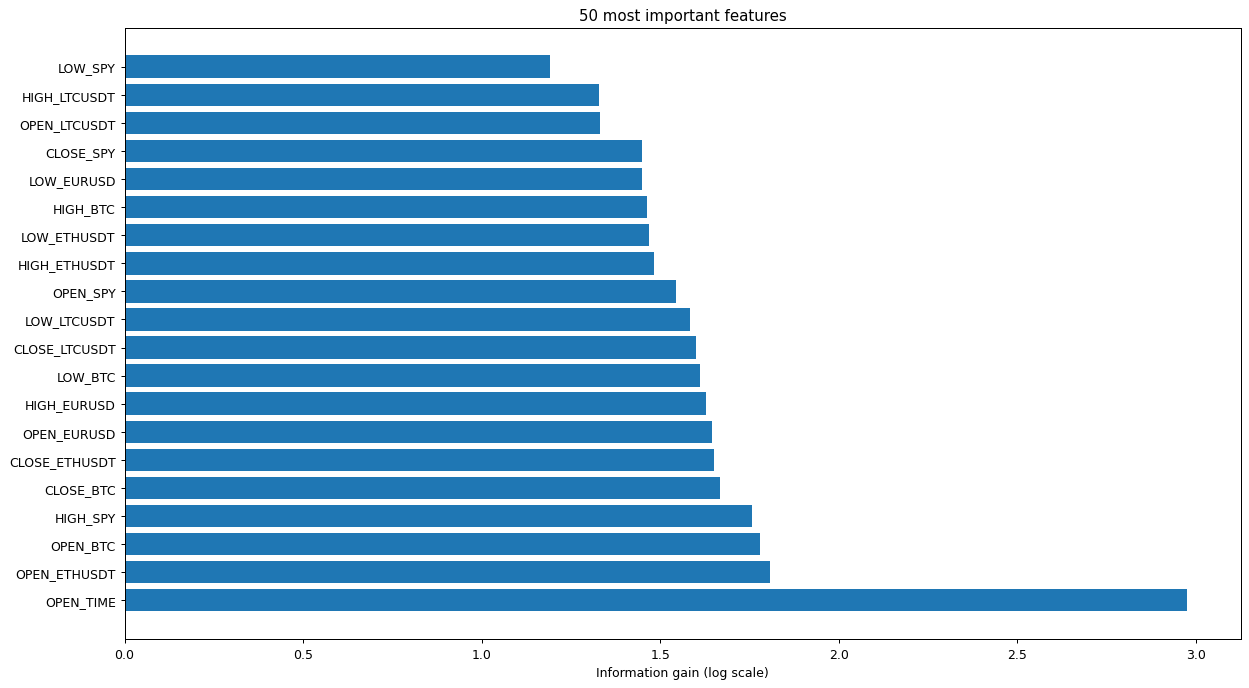

In [60]:
plot_feat_imp = feat_imp.sort_values("Feature Importance", ascending=False).iloc[:50,:]

def cal_log(x):
    return np.log10(x)

plt.figure(figsize=(16,9), dpi=90)
plt.title("50 most important features")
plt.barh(plot_feat_imp["Name"],plot_feat_imp["Feature Importance"].apply(cal_log))
plt.xlabel("Information gain (log scale)")
plt.show()

In [42]:
feat

,Name,Feature Importance
0,OPEN_TIME,946.138702
5,OPEN_ETHUSDT,64.263326
1,OPEN_BTC,60.264377
13,HIGH_SPY,57.044073
2,CLOSE_BTC,46.626105
7,CLOSE_ETHUSDT,44.754749
17,OPEN_EURUSD,44.208613
18,HIGH_EURUSD,42.583337
3,LOW_BTC,40.737817
9,CLOSE_LTCUSDT,39.949545


In [35]:
path_model = '/content/gdrive/MyDrive/NESTQUANT/models/'
model.save_model(path_model+"UpdatedBestmodel.txt")